<a href="https://colab.research.google.com/github/2018007956/KISTI-NVIDIA-HACKATHON2022/blob/main/Exercise/LEVEL1/4.%20DL%20Basic/(4%E1%84%80%E1%85%A1%E1%86%BC_%E1%84%89%E1%85%B5%E1%86%AF%E1%84%89%E1%85%B3%E1%86%B8)_Covolutional_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network (CNN)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[2.1.0+cu118].
device:[cuda:0].


### Dataset

In [2]:
from torchvision import datasets,transforms
mnist_train = datasets.MNIST(root='./data/',train=True,transform=transforms.ToTensor(),download=True)
mnist_test = datasets.MNIST(root='./data/',train=False,transform=transforms.ToTensor(),download=True)
print ("mnist_train:\n",mnist_train,"\n")
print ("mnist_test:\n",mnist_test,"\n")
print ("Done.")

100%|██████████| 9912422/9912422 [00:00<00:00, 277358162.79it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 41684684.73it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 65722919.72it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22386050.26it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

mnist_train:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor() 

mnist_test:
 Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: ToTensor() 

Done.


### Data Iterator

In [3]:
BATCH_SIZE = 256
train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
print ("Done.")

Done.


### Define Model

In [7]:
class ConvolutionalNeuralNetworkClass(nn.Module):
    """
        Convolutional Neural Network (CNN) Class
    """
    def __init__(self,name='cnn',xdim=[1,28,28],
                 ksize=3,cdims=[32,64],hdims=[1024,128],ydim=10,
                 USE_BATCHNORM=False):
        super(ConvolutionalNeuralNetworkClass,self).__init__()
        self.name = name
        self.xdim = xdim
        self.ksize = ksize
        self.cdims = cdims # Channel dimension
        self.hdims = hdims
        self.ydim = ydim
        self.USE_BATCHNORM = USE_BATCHNORM

        # Convolutional layers
        self.layers = []
        prev_cdim = self.xdim[0]
        for cdim in self.cdims: # for each hidden layer
            self.layers.append( # convlution
                nn.Conv2d(in_channels=prev_cdim,
                          out_channels=cdim,
                          kernel_size=self.ksize,
                          stride=(1,1),
                          padding=self.ksize//2)) # input convolutional feature map의 special dimension이 출력에서 똑같은 사이즈로 나옴
            if self.USE_BATCHNORM:
                self.layers.append(nn.BatchNorm2d(cdim)) # batch-norm
            self.layers.append(nn.ReLU(True))  # activation
            self.layers.append(nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))) # max-pooling
            self.layers.append(nn.Dropout2d(p=0.5))  # dropout
            prev_cdim = cdim

        # Dense layers
        self.layers.append(nn.Flatten())
        prev_hdim = prev_cdim*(self.xdim[1]//(2**len(self.cdims)))*(self.xdim[2]//(2**len(self.cdims)))
        for hdim in self.hdims:
            self.layers.append(nn.Linear(prev_hdim,hdim,bias=True))
            self.layers.append(nn.ReLU(True))  # activation
            prev_hdim = hdim
        # Final layer (without activation)
        self.layers.append(nn.Linear(prev_hdim,self.ydim,bias=True))

        # Concatenate all layers
        self.net = nn.Sequential()
        for l_idx,layer in enumerate(self.layers):
            layer_name = "%s_%02d"%(type(layer).__name__.lower(),l_idx)
            self.net.add_module(layer_name,layer) # add_module의 장점 : 이름 지정 가능 (-> 교수님이 nn.Sequential을 쓰시는 가장 큰 이유)
        self.init_param() # initialize parameters

    def init_param(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d): # init conv
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m,nn.BatchNorm2d): # init BN
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear): # lnit dense
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self,x):
        return self.net(x)

# Image : 28x28x1 -> 14x14x32 -> 7x7x64 -> flatten -> 256 -> 128 -> 10
C = ConvolutionalNeuralNetworkClass(
    name='cnn',xdim=[1,28,28],ksize=3,cdims=[32,64],
    hdims=[256,128],ydim=10).to(device)
loss = nn.CrossEntropyLoss()
optm = optim.Adam(C.parameters(),lr=1e-3)
print ("Done.")

Done.


### Check Parameters

In [8]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx,(param_name,param) in enumerate(C.named_parameters()):
    if param.requires_grad:
        param_numpy = param.detach().cpu().numpy() # to numpy array
        n_param += len(param_numpy.reshape(-1))
        print ("[%d] name:[%s] shape:[%s]."%(p_idx,param_name,param_numpy.shape))
        print ("    val:%s"%(param_numpy.reshape(-1)[:5]))
print ("Total number of parameters:[%s]."%(format(n_param,',d')))

[0] name:[net.conv2d_00.weight] shape:[(32, 1, 3, 3)].
    val:[ 0.499 -0.293  0.002  0.896 -0.161]
[1] name:[net.conv2d_00.bias] shape:[(32,)].
    val:[0. 0. 0. 0. 0.]
[2] name:[net.conv2d_04.weight] shape:[(64, 32, 3, 3)].
    val:[ 0.211 -0.023 -0.044  0.009  0.031]
[3] name:[net.conv2d_04.bias] shape:[(64,)].
    val:[0. 0. 0. 0. 0.]
[4] name:[net.linear_09.weight] shape:[(256, 3136)].
    val:[ 0.033 -0.007 -0.019  0.036  0.03 ]
[5] name:[net.linear_09.bias] shape:[(256,)].
    val:[0. 0. 0. 0. 0.]
[6] name:[net.linear_11.weight] shape:[(128, 256)].
    val:[-0.173  0.037 -0.076  0.01  -0.034]
[7] name:[net.linear_11.bias] shape:[(128,)].
    val:[0. 0. 0. 0. 0.]
[8] name:[net.linear_13.weight] shape:[(10, 128)].
    val:[-0.001  0.013  0.106  0.037  0.017]
[9] name:[net.linear_13.bias] shape:[(10,)].
    val:[0. 0. 0. 0. 0.]
Total number of parameters:[856,074].


### Simple Forward Path of the CNN Model

In [9]:
np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)
x_numpy = np.random.rand(2,1,28,28) # 2 : batch
x_torch = torch.from_numpy(x_numpy).float().to(device)
y_torch = C.forward(x_torch) # forward path
y_numpy = y_torch.detach().cpu().numpy() # torch tensor to numpy array
print ("x_torch:\n",x_torch)
print ("y_torch:\n",y_torch)
print ("\nx_numpy %s:\n"%(x_numpy.shape,),x_numpy)
print ("y_numpy %s:\n"%(y_numpy.shape,),y_numpy)

x_torch:
 tensor([[[[4.368e-01, 8.506e-02, 6.052e-01,  ..., 5.072e-01, 6.346e-04,
           3.210e-02],
          [8.611e-01, 9.337e-01, 2.336e-01,  ..., 5.386e-01, 2.557e-01,
           5.671e-01],
          [8.798e-01, 3.442e-01, 2.211e-01,  ..., 7.054e-01, 8.082e-01,
           3.609e-01],
          ...,
          [9.556e-01, 6.701e-01, 4.151e-01,  ..., 1.211e-01, 2.036e-01,
           6.585e-01],
          [1.523e-01, 8.859e-02, 8.878e-01,  ..., 9.610e-02, 2.941e-01,
           6.764e-01],
          [7.289e-01, 6.154e-01, 7.872e-01,  ..., 4.197e-01, 2.078e-01,
           1.179e-01]]],


        [[[9.747e-02, 9.800e-01, 2.566e-01,  ..., 9.673e-01, 6.192e-01,
           7.113e-01],
          [6.121e-01, 7.307e-01, 2.313e-01,  ..., 2.497e-01, 8.673e-01,
           6.942e-01],
          [4.455e-01, 3.896e-01, 3.185e-01,  ..., 3.696e-01, 6.501e-01,
           5.830e-01],
          ...,
          [1.267e-01, 6.229e-01, 7.540e-01,  ..., 3.491e-01, 7.421e-01,
           2.253e-01],
      

### Evaluation Function

In [10]:
def func_eval(model,data_iter,device):
    with torch.no_grad():
        n_total,n_correct = 0,0
        model.eval() # evaluate (affects DropOut and BN)
        for batch_in,batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model(batch_in.view(-1,1,28,28).to(device))
            _,y_pred = torch.max(model_pred.data,1)
            n_correct += (y_pred==y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
        model.train() # back to train mode
    return val_accr
print ("Done")

Done


### Initial Evaluation

In [11]:
C.init_param() # initialize parameters
train_accr = func_eval(C,train_iter,device)
test_accr = func_eval(C,test_iter,device)
print ("train_accr:[%.3f] test_accr:[%.3f]."%(train_accr,test_accr))
# Random guess -> 10 classes이므로 약 10%

train_accr:[0.083] test_accr:[0.081].


### Train

In [12]:
print ("Start training.")
C.init_param() # initialize parameters
C.train() # to train mode
EPOCHS,print_every = 10,1
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_in,batch_out in train_iter:
        # Forward path
        y_pred = C.forward(batch_in.view(-1,1,28,28).to(device))
        loss_out = loss(y_pred,batch_out.to(device))
        # Update
        optm.zero_grad() # reset gradient
        loss_out.backward() # backpropagate
        optm.step() # optimizer update
        loss_val_sum += loss_out
    loss_val_avg = loss_val_sum/len(train_iter)
    # Print
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        train_accr = func_eval(C,train_iter,device)
        test_accr = func_eval(C,test_iter,device)
        print ("epoch:[%d] loss:[%.3f] train_accr:[%.3f] test_accr:[%.3f]."%
               (epoch,loss_val_avg,train_accr,test_accr))
print ("Done")

Start training.
epoch:[0] loss:[0.456] train_accr:[0.968] test_accr:[0.971].
epoch:[1] loss:[0.137] train_accr:[0.980] test_accr:[0.980].
epoch:[2] loss:[0.096] train_accr:[0.986] test_accr:[0.986].
epoch:[3] loss:[0.077] train_accr:[0.991] test_accr:[0.988].
epoch:[4] loss:[0.065] train_accr:[0.991] test_accr:[0.990].
epoch:[5] loss:[0.058] train_accr:[0.992] test_accr:[0.989].
epoch:[6] loss:[0.051] train_accr:[0.994] test_accr:[0.989].
epoch:[7] loss:[0.046] train_accr:[0.995] test_accr:[0.990].
epoch:[8] loss:[0.042] train_accr:[0.995] test_accr:[0.990].
epoch:[9] loss:[0.040] train_accr:[0.995] test_accr:[0.992].
Done


Multi Layer Perceptron과 가장 큰 차이점 : train accuracy와 test accuracy의 차이가 많이 없다. 즉 generalization performance가 훨씬 좋음.
CNN 모델이 가지고 있는 특성 (이미지에 더 적합하기) 때문

### Test

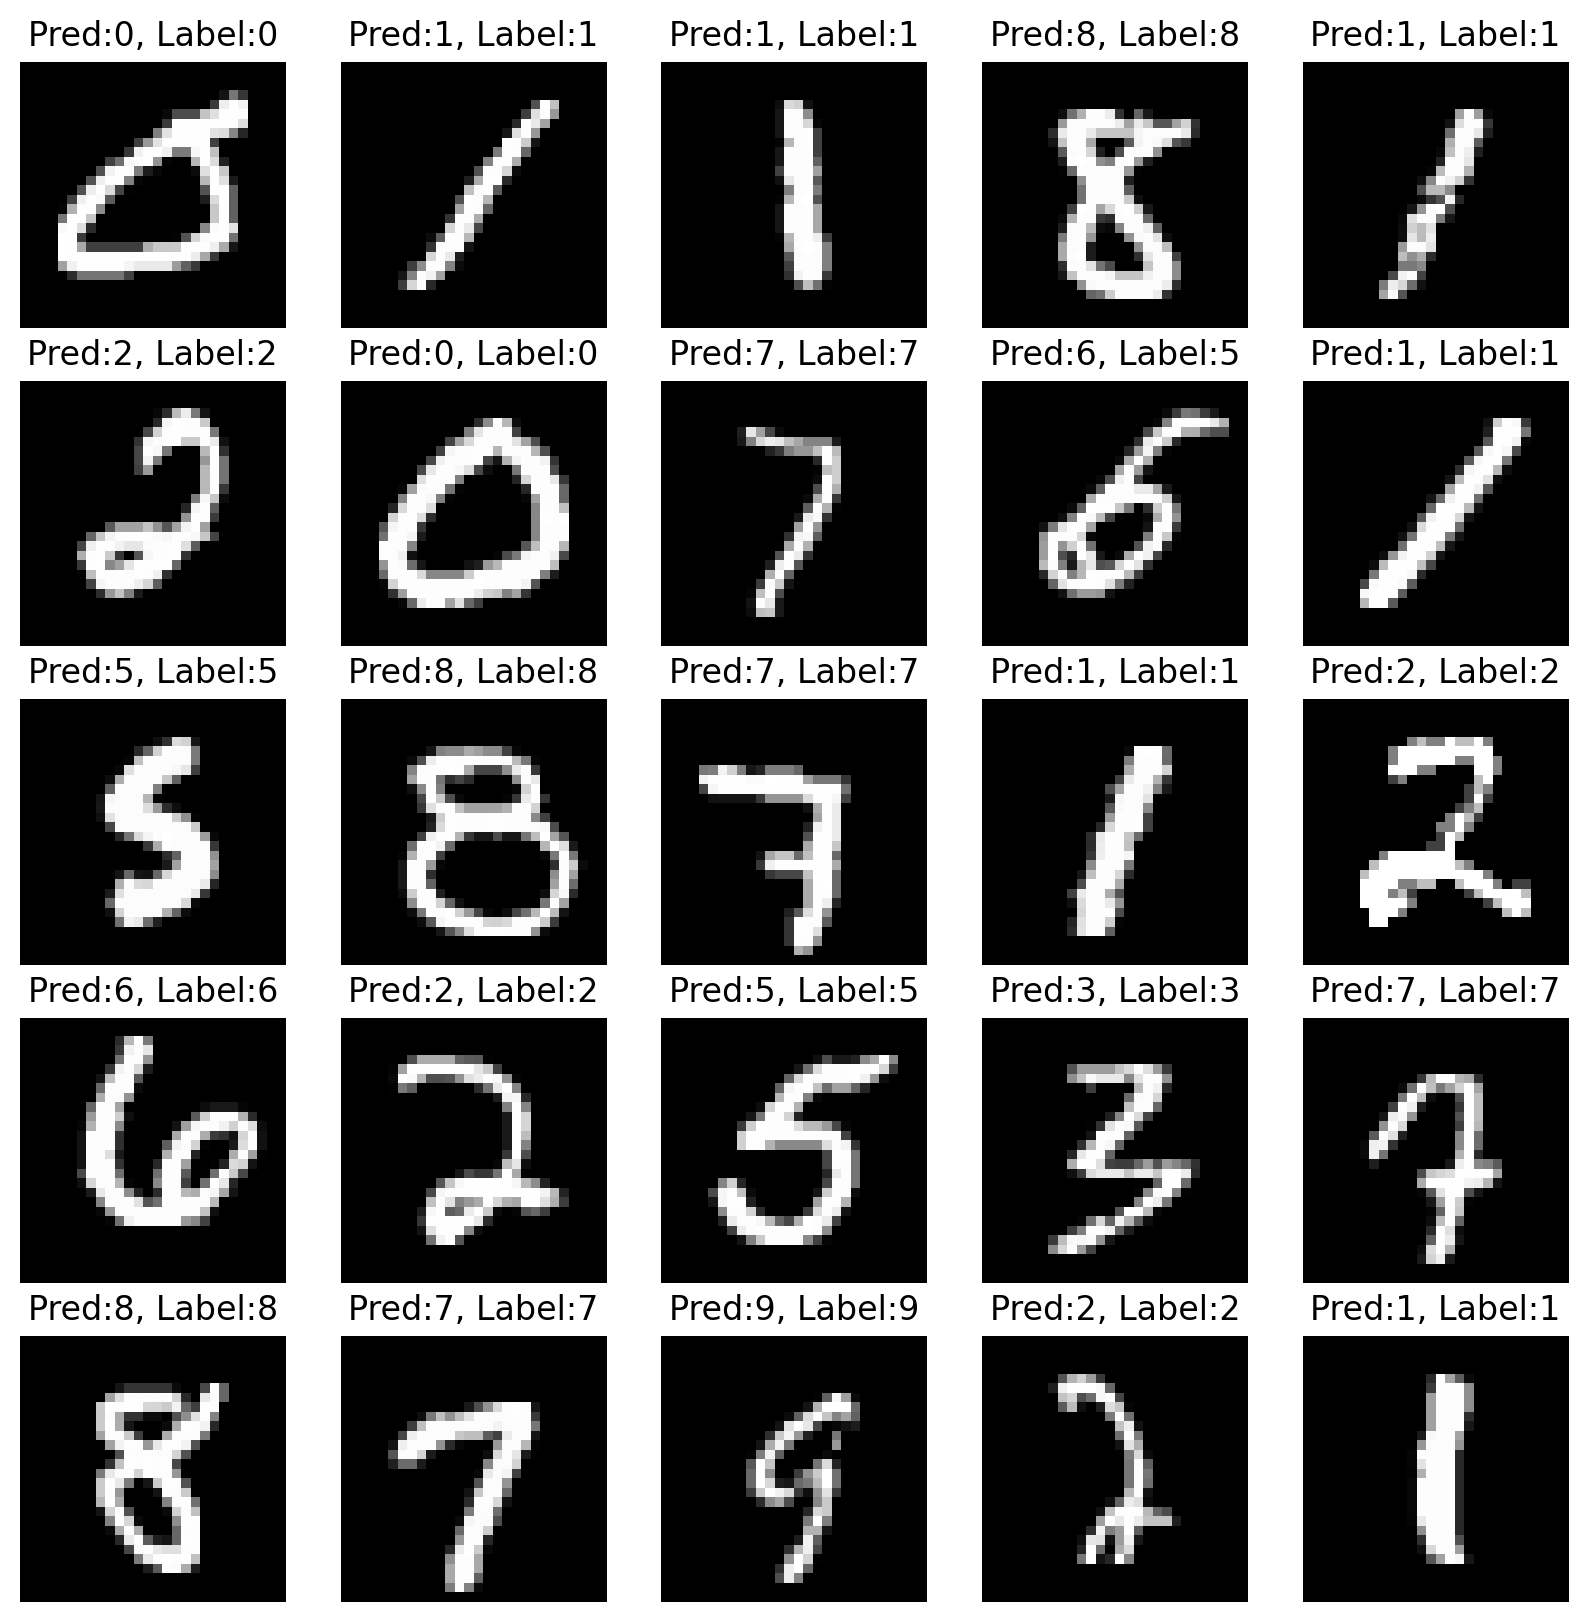

Done


In [13]:
n_sample = 25
sample_indices = np.random.choice(len(mnist_test.targets),n_sample,replace=False)
test_x = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]
with torch.no_grad():
    C.eval() # to evaluation mode
    y_pred = C.forward(test_x.view(-1,1,28,28).type(torch.float).to(device)/255.)
y_pred = y_pred.argmax(axis=1)
plt.figure(figsize=(10,10))
for idx in range(n_sample):
    plt.subplot(5, 5, idx+1)
    plt.imshow(test_x[idx], cmap='gray')
    plt.axis('off')
    plt.title("Pred:%d, Label:%d"%(y_pred[idx],test_y[idx]))
plt.show()
print ("Done")

###**콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.

